In [1]:
#%matplotlib notebook
%matplotlib inline
#%config InlineBackend.figure_formats=['svg']
#%config InlineBackend.figure_formats=['pdf']

import matplotlib

matplotlib.rcParams['figure.figsize'] = (12, 9)

from IPython.display import display

import scipy
import scipy.stats
import math
import numpy as np
import pandas as pd

#import ipywidgets
#from ipywidgets import interact

#import sys
#sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils/")
#import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
CSV_FILE_PATH = "../xps/best.csv"

#WAVELET_LABEL = "Wavelets-n4-K-k-C1-s3-m3-kill"
#WAVELET_LABEL = "WT-ref-f3-s3"
#WAVELET_LABEL = "WT-t24-f3-s4"
#WAVELET_LABEL = "WT-t28-f3-s5"
WAVELET_LABEL = "WT-ref-s2-2-3-3"

TAILCUT_LABEL = "Tailcut-5-10-kill"

PART = 0         # 0 for gamma, 1 for protons

FAINT_BRIGHT_BORDER = 100

full_df = pd.read_csv(CSV_FILE_PATH)

ref = full_df[full_df.Type == 'Ref']
ref = ref[ref.Part == PART]

tc = full_df[full_df.Type == TAILCUT_LABEL]
tc = tc[tc.Part == PART]

wt = full_df[full_df.Type == WAVELET_LABEL]
wt = wt[wt.Part == PART]


tc_wt = pd.merge(tc, wt, on="Id", how="outer", suffixes=('_tc', '_wt'))  #.dropna(how='any')
df = pd.merge(tc_wt, ref, on="Id", how="outer")

df["delta_tc"] = np.fmod(((df['hPsi'] - df['hPsi_tc']) * 180. / np.pi), 90.)
df["delta_wt"] = np.fmod(((df['hPsi'] - df['hPsi_wt']) * 180. / np.pi), 90.)

df.delta_tc = abs(df.delta_tc)
df.delta_wt = abs(df.delta_wt)

df["delta_pe_tc"] = df.delta_tc * df.peSum_tc
df["delta_pe_wt"] = df.delta_wt * df.peSum_wt

#df = df[df.border > 0]   # CONTAINED
#df = df[df.border == 0]  # NOT CONTAINED

grpdf = df.groupby(["Evt"])

## Number of fails

In [3]:
print("TC:", np.sum(grpdf.peSum.count() - grpdf.peSum_tc.count()), "failed")
print("WT:", np.sum(grpdf.peSum.count() - grpdf.peSum_wt.count()), "failed")

# Check
print("TC:", len(df[df.Success_tc == 0]), "failed")
print("WT:", len(df[df.Success_wt == 0]), "failed")

TC: 371 failed
WT: 0 failed
TC: 371 failed
WT: 0 failed


## Mean number of telescope per event

In [4]:
print("Ref. mean={:.2f}, med={:.2f}, std={:.2f}".format( grpdf.peSum.count().mean(), grpdf.peSum.count().median(), grpdf.peSum.count().std() ))
print("TC   mean={:.2f}, med={:.2f}, std={:.2f}".format( grpdf.peSum_tc.count().mean(), grpdf.peSum_tc.count().median(), grpdf.peSum_tc.count().std() ))
print("WT   mean={:.2f}, med={:.2f}, std={:.2f}".format( grpdf.peSum_wt.count().mean(), grpdf.peSum_wt.count().median(), grpdf.peSum_wt.count().std() ))

Ref. mean=4.56, med=3.00, std=4.58
TC   mean=4.45, med=3.00, std=4.50
WT   mean=4.56, med=3.00, std=4.58


## Number of telescope per event after cleaning

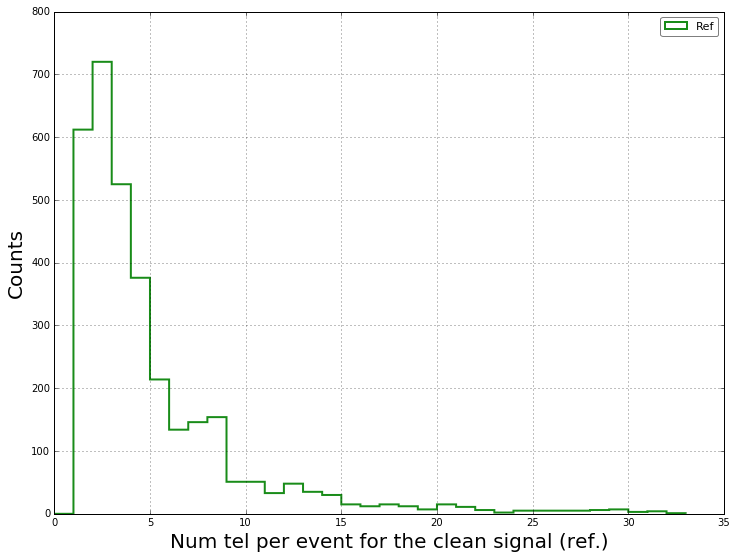

In [5]:
fig, ax = plt.subplots()

bins = np.arange(0, 34)

grpdf.peSum.count().hist(bins=bins, label="Ref", linewidth=2, alpha=0.9, color='green', histtype="step")

#ax.set_yscale('log')

ax.set_xlabel('Num tel per event for the clean signal (ref.)', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)

ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

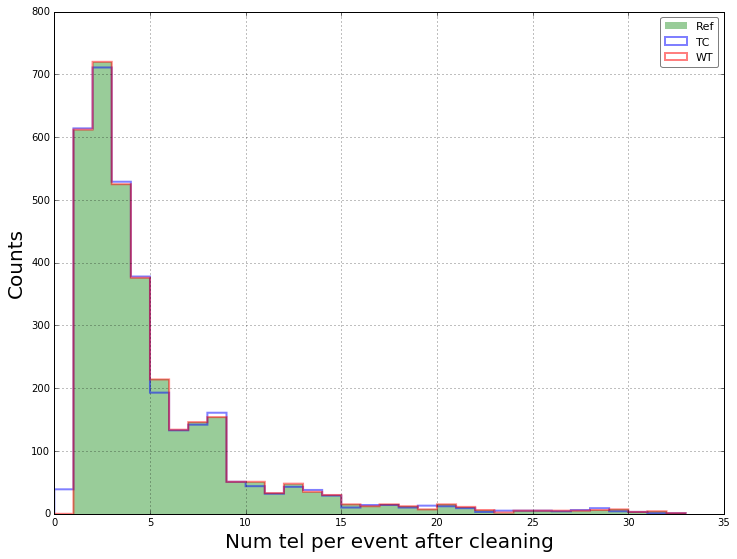

In [6]:
fig, ax = plt.subplots()

bins = np.arange(0, 34)

grpdf.peSum.count().hist(bins=bins, label="Ref", linewidth=0, alpha=0.4, color='green', histtype="bar")
grpdf.peSum_tc.count().hist(bins=bins, label="TC", linewidth=2, alpha=0.5, color='blue', histtype="step")
grpdf.peSum_wt.count().hist(bins=bins, label="WT", linewidth=2, alpha=0.5, color='red', histtype="step")

#ax.set_yscale('log')

ax.set_xlabel('Num tel per event after cleaning', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)

ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

## PE sum

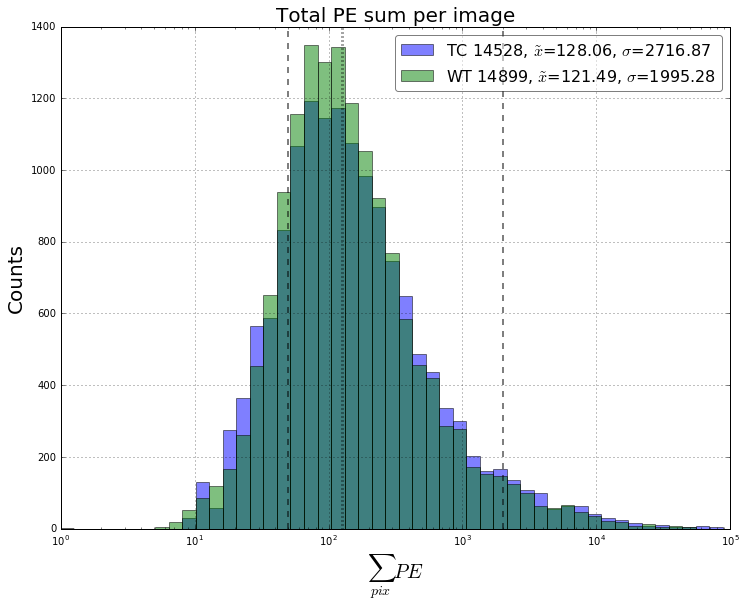

In [7]:
fig, ax = plt.subplots()

max_value = max(np.max(df.peSum_tc), np.max(df.peSum_wt))
bins = np.logspace(0, np.log10(max_value), 50)

df.peSum_tc.hist(bins=bins, alpha=0.5,
                 label=r"TC {}, $\tilde x$={:.2f}, $\sigma$={:.2f}".format(len(df.peSum_tc.dropna()),
                                                                           df.peSum_tc.median(),
                                                                           #df.peSum_tc.mean(),
                                                                           df.peSum_tc.std()))
df.peSum_wt.hist(bins=bins, alpha=0.5,
                 label=r"WT {}, $\tilde x$={:.2f}, $\sigma$={:.2f}".format(len(df.peSum_wt.dropna()),
                                                                           df.peSum_wt.median(),
                                                                           #df.peSum_wt.mean(),
                                                                           df.peSum_wt.std()))

ax.axvline(x=50, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=2000, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=125, linewidth=3, linestyle=':', color='black', alpha=0.7)

ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel(r'$\sum_{pix} PE$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)

ax.set_title("Total PE sum per image", fontsize=20)

ax.legend(prop={'size': 16}, loc='best', fancybox=True, framealpha=0.5)

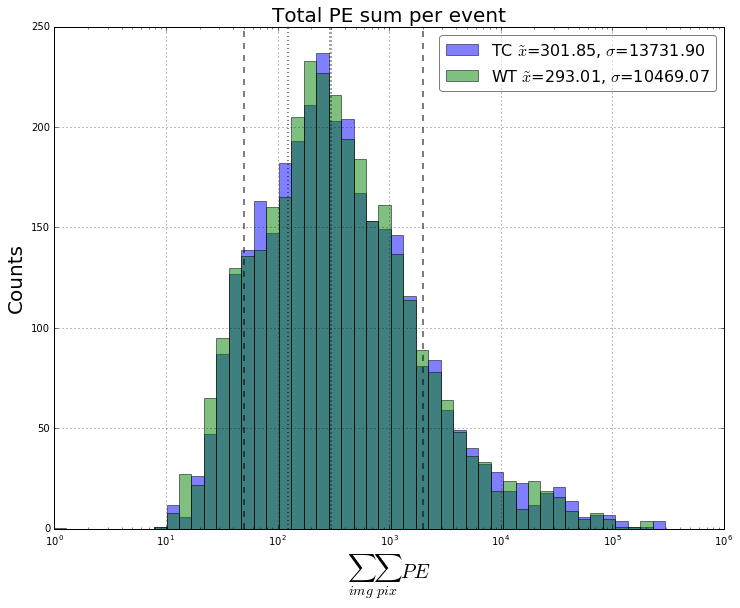

In [8]:
fig, ax = plt.subplots()

max_value = max(np.max(grpdf.peSum_tc.sum()), np.max(grpdf.peSum_wt.sum()))
bins = np.logspace(0, np.log10(max_value), 50)

grpdf.peSum_tc.sum().hist(bins=bins, alpha=0.5,
                          label=r"TC $\tilde x$={:.2f}, $\sigma$={:.2f}".format(grpdf.peSum_tc.sum().median(),
                                                                                grpdf.peSum_tc.sum().std()))
grpdf.peSum_wt.sum().hist(bins=bins, alpha=0.5,
                          label=r"WT $\tilde x$={:.2f}, $\sigma$={:.2f}".format(grpdf.peSum_wt.sum().median(),
                                                                                grpdf.peSum_wt.sum().std()))

ax.axvline(x=50, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=2000, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=125, linewidth=2, linestyle=':', color='black', alpha=0.5)
ax.axvline(x=297, linewidth=3, linestyle=':', color='black', alpha=0.7)

ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel(r'$\sum_{img} \sum_{pix} PE$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)

ax.set_title("Total PE sum per event", fontsize=20)

ax.legend(prop={'size': 16}, loc='best', fancybox=True, framealpha=0.5)

## Delta psi

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


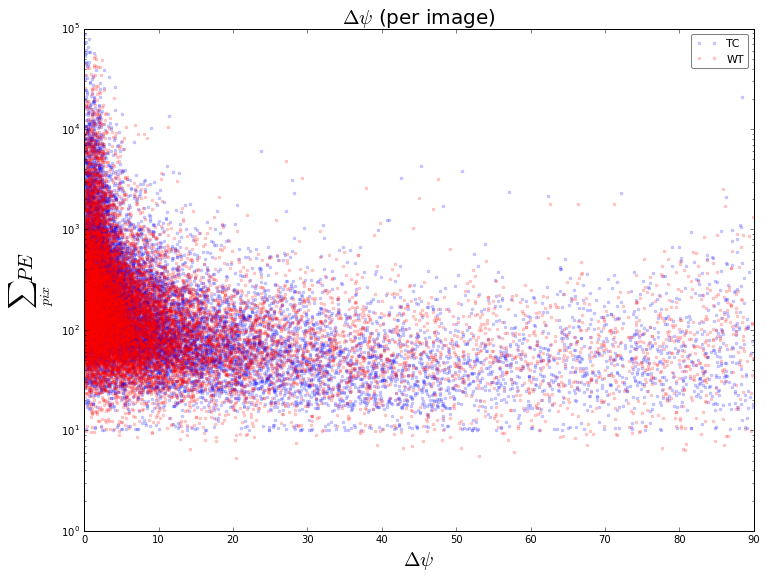

In [9]:
fig, ax = plt.subplots()

ax.plot(df.delta_tc, df.peSum_tc, ".b", alpha=0.2, label="TC")
ax.plot(df.delta_wt, df.peSum_wt, ".r", alpha=0.2, label="WT")

#ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta\psi$', fontsize=20)
ax.set_ylabel(r'$\sum_{pix} PE$', fontsize=20)

ax.set_title(r"$\Delta\psi$ (per image)", fontsize=20)

ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


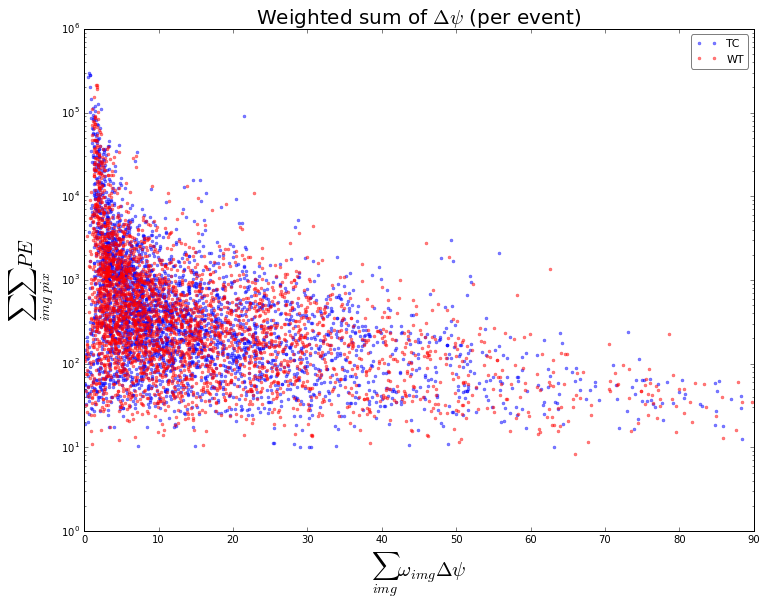

In [10]:
fig, ax = plt.subplots()

ax.plot(grpdf.delta_pe_tc.sum() / grpdf.peSum_tc.sum(), grpdf.peSum_tc.sum(), ".b", alpha=0.5, label="TC")
ax.plot(grpdf.delta_pe_wt.sum() / grpdf.peSum_wt.sum(), grpdf.peSum_wt.sum(), ".r", alpha=0.5, label="WT")

#ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\sum_{img} \omega_{img} \Delta\psi$', fontsize=20)
ax.set_ylabel(r'$\sum_{img} \sum_{pix} PE$', fontsize=20)

ax.set_title(r"Weighted sum of $\Delta\psi$ (per event)", fontsize=20)

ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

$$
\sum_{img} \omega_{img} \Delta\psi
$$
with
$$
\omega_{img} = \frac{\sum_{pix} PE}{\sum_{img}\sum_{pix} PE}
$$

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


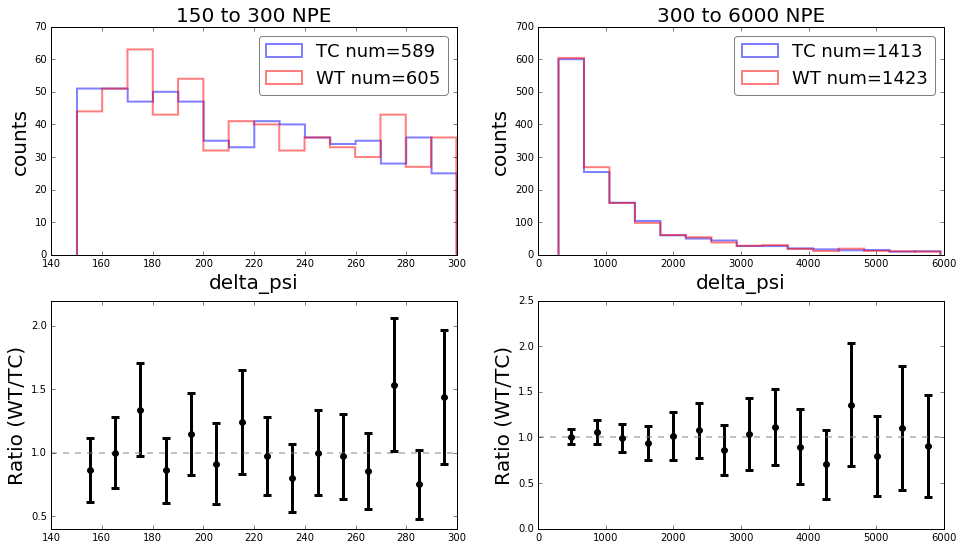

In [11]:
def plot_ratio(ax, res_tuple_tc, res_tuple_wt):
    val_of_bins_tc, bins_tc, patches_tc = res_tuple_tc
    val_of_bins_wt, bins_wt, patches_wt = res_tuple_wt
    edges_of_bins = bins_tc

    # Set ratio where val_of_bins_data is not zero
    ratio = np.divide(val_of_bins_wt,
                      val_of_bins_tc,
                      where=(val_of_bins_tc != 0))

    # Compute error on ratio (null if cannot be computed)
    # This is wrong as it's made for Gaussian distributions and here we have Poisson distribution
    error = np.divide(val_of_bins_wt * np.sqrt(val_of_bins_tc) + val_of_bins_tc * np.sqrt(val_of_bins_wt),
                       np.power(val_of_bins_tc, 2),
                       where=(val_of_bins_tc != 0))

    ax.set_ylabel('Ratio (WT/TC)', fontsize=20)
    ax.axhline(y=1, linewidth=2, linestyle='--', color='gray', alpha=0.5)

    bincenter = 0.5 * (edges_of_bins[1:] + edges_of_bins[:-1])
    ax.errorbar(bincenter, ratio, yerr=error, fmt='o', color='k', elinewidth=3, capsize=4, capthick=3, linewidth=6)
    ax.plot(bincenter, ratio, 'ok', linewidth=6)

################################

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

#BINS_START, BINS_STOP, BINS_STEP = 0., 99., 9.
#BINS_START, BINS_STOP, BINS_STEP = 0., 99., 9.

#BINS = np.arange(BINS_START, BINS_STOP, BINS_STEP)
#BINS = 30
#BINS = np.linspace(BINS_START, BINS_STOP, 30)
#BINS = [3.53056780e-03, 5.99515231e+00, 1.19867741e+01, 1.79783958e+01, 2.39700176e+01, 2.99616393e+01,
#        3.59532610e+01, 4.19448828e+01, 4.79365045e+01, 5.39281263e+01, 5.99197480e+01, 6.59113698e+01,
#        7.19029915e+01, 7.78946133e+01, 8.38862350e+01, 8.98778568e+01]
BINS = 15

################################

NPE_MIN, NPE_MAX = 150, 300

dftc = pd.DataFrame({"delta": grpdf.delta_pe_tc.sum() / grpdf.peSum_tc.sum(),
                     "peSum": grpdf.peSum_tc.sum()})
dfwt = pd.DataFrame({"delta": grpdf.delta_pe_wt.sum() / grpdf.peSum_wt.sum(),
                     "peSum": grpdf.peSum_wt.sum()})

df1 = dftc[dftc.peSum > NPE_MIN][dftc.peSum <= NPE_MAX]["peSum"]
df2 = dfwt[dfwt.peSum > NPE_MIN][dfwt.peSum <= NPE_MAX]["peSum"]

res_tuple_tc1 = ax1.hist(df1,
                         label="TC num={}".format(len(df1)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='blue', histtype="step")

res_tuple_wt1 = ax1.hist(df2,
                         label="WT num={}".format(len(df2)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='red',  histtype="step")

ax1.set_title("{} to {} NPE".format(NPE_MIN, NPE_MAX), fontsize=20)
ax1.set_xlabel("delta_psi", fontsize=20)
ax1.set_ylabel("counts", fontsize=20)
ax1.legend(prop={'size': 18}, loc='best', fancybox=True, framealpha=0.5)

plot_ratio(ax3, res_tuple_tc1, res_tuple_wt1)

################################

NPE_MIN, NPE_MAX = 300, 6000

df1 = dftc[dftc.peSum > NPE_MIN][dftc.peSum <= NPE_MAX]["peSum"]
df2 = dfwt[dfwt.peSum > NPE_MIN][dfwt.peSum <= NPE_MAX]["peSum"]

res_tuple_tc2 = ax2.hist(df1,
                         label="TC num={}".format(len(df1)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='blue', histtype="step")

res_tuple_wt2 = ax2.hist(df2,
                         label="WT num={}".format(len(df2)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='red',  histtype="step")

ax2.set_title("{} to {} NPE".format(NPE_MIN, NPE_MAX), fontsize=20)
ax2.set_xlabel("delta_psi", fontsize=20)
ax2.set_ylabel("counts", fontsize=20)
ax2.legend(prop={'size': 18}, loc='best', fancybox=True, framealpha=0.5)

plot_ratio(ax4, res_tuple_tc2, res_tuple_wt2)

#ax.set_yscale('log')

## Delta psi from script

Rem: this is a cross check, you can ignore it...

In [12]:
#%run ./utils/plot_delta_psi.py --notebook --metric hillas2_delta_psi_norm2 xps/2017_02_23_sapcta/run_8/score_gamma_all_wavelets_mrfilter_kill.json xps/2017_02_22_sapcta/run_1/score_gamma_all_tailcut_kill.json